This notebook demonstrates model fits on some synthetic noise-free data.

In [1]:
from BranchedGP.MBGP.data_generation import ToyBranchedData, GeneExpressionData
from BranchedGP.MBGP.training_helpers import TrainingOutcome, get_training_outcome
from BranchedGP.MBGP.assigngp import AssignGP
from BranchedGP.MBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np


def plot_detailed_fit(
        outcomes: TrainingOutcome, 
        genes: GeneExpressionData, 
        alpha: float = 0.01, 
        title: bool=True,
        axa_per_row: int=4,
) -> None:
    fig, axa = genes.plot(max_samples_per_gene=5000, alpha=alpha, axa_per_row=axa_per_row)
    if title:
        fig.suptitle(
            f"ELBO: {outcomes.model.training_loss():.2f}, "
            f"lengthscale: {outcomes.model.kernel.kern.lengthscales.numpy():.2f}, "
            f"variance: {outcomes.model.kernel.kern.variance.numpy() + outcomes.model.likelihood.variance.numpy():.2f}, "
        )

    for ib, ax in enumerate(axa.flatten()):
        try:
            plotBranchModel(
                outcomes.learned_branching_points[ib], None, None, genes.t, genes.Y, 
                np.vstack((outcomes.predictions.x,) * 3), outcomes.predictions.y_mean, outcomes.predictions.y_var,
                outcomes.model.logPhi, fPlotVar=False, d=ib, ax=ax, 
                fColorBar=False, fPlotPhi=False, show_legend=False
            )
        except IndexError:
            # Work around empty axes in the axa object
            pass
    return fig, axa


def plot_model_snapshot(
        model: AssignGP, 
        genes: GeneExpressionData, 
        alpha: float = 0.01, 
        title: bool=True,
        axa_per_row: int=4,
) -> None:
    details = get_training_outcome(model)
    fig, axa = plot_detailed_fit(details, genes, alpha=alpha, title=title, axa_per_row=axa_per_row)
    return fig, axa

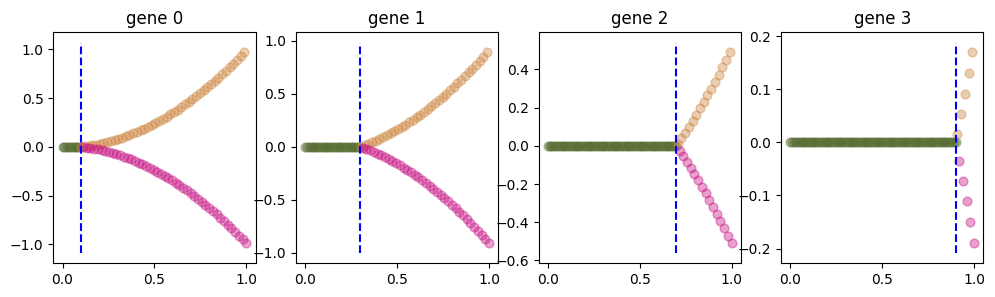

In [2]:
data = ToyBranchedData([0.1, 0.3, 0.7, 0.9], N=100)
fig, axa = data.plot()

In [3]:
from BranchedGP.MBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow


m = construct_assigngp_model(
    gene_expression=data,
    phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
    initial_branching_points=[0.5]*data.num_genes,
)

# The following optimiser defaults to 4 equidistant initial BPs and 
# does gradient descent on ELBO 
optimiser = ElvijsAmazingOptimiser(base_optimiser=ScipyOptimiser())

trained_m = optimiser.train(m)

Metal device set to: Apple M1


2023-05-10 22:12:19.963391: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


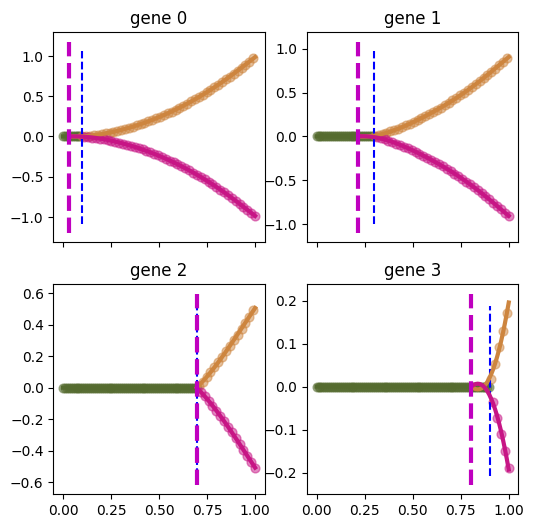

In [4]:
fig, axa = plot_model_snapshot(trained_m, data, alpha=0.5, title=False, axa_per_row=2)
plt.show()

In [5]:
fig.savefig("synthetic_noise_free.png")